# Generate Paper Plots

In [26]:
from eval_model_helpers import *
sys.path.append(os.path.join('..'))
from models.func_to_func2d_invasive import FNO2d
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import yaml

#### Set plot defaults

In [27]:
# Plot defaults
# Set font default
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = ['Dejavu Serif'] #'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'Dejavu Serif'
plt.rcParams['font.serif'] = ['Times'] #['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times

tickfontsize = 33
fontsize = 33
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']


#### Set parameters

In [28]:
s_vals = [0.5, 1.0, 1.5, 2.0]
sizes = [64, 128, 256 , 512, 1024, 2048]
plot_sizes = sizes[:-1]

#### Error evaluation function for each layer

In [29]:

def get_err_norms(s,model_name, sizes = [32, 64, 128, 256]):
    # model_name = 'initial_model_K_12_0_all1'
    model_info_path = '../models/untrained_models/' + model_name + '_info.yaml'
    model_path = '../models/untrained_models/' + model_name + '.pt'

    samp_count_model = 1
    samp_count_input = 5
    true_size = sizes[-1]
  
    # Load model
    model = load_model(model_info_path, model_path,s_outputspace = (true_size,true_size))
    model_info = load_model_info(model_info_path)
    n_layers = model_info['n_layers']-1

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_model, samp_count_input)

    for input_i in range(samp_count_input):
        true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        layers_true = get_layer_output(model,input_true)

        for size_i, size in enumerate(sizes[:-1]):
            disc_input_path = '../data/GRF_s' +str(s) + f'_GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            layers_disc = get_layer_output(model,input_disc)
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer] - layers_true[layer])
                all_err[size_i,layer, 0, input_i] = err

                true_norms[layer, input_i] = torch.norm(layers_true[layer])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_model*samp_count_input)

    return all_err, true_norms


In [30]:
def evaluate_model(model_name,s_vals,sizes):
    all_err_s = []
    true_norms_s = []
    for s in s_vals:
        all_err, true_norms = get_err_norms(s,model_name,sizes=sizes)
        all_err_s.append(all_err)
        true_norms_s.append(true_norms)

    true_norms_s = np.array(true_norms_s)
    all_err_s = np.array(all_err_s)
    return all_err_s, true_norms_s

In [31]:
def normalize_err(all_err_s,true_norms_s):
    # Normalize all_err_s by true_norms_s
    n_layers = true_norms_s.shape[1]
    all_err_s = np.array(all_err_s)
    n_samples = all_err_s.shape[-1]
    all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
    for i in range(len(s_vals)):
        for j in range(n_layers):
            all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]
    return all_err_s_norm

In [32]:
def plot_err_vs_N(all_err_s_norm,plot_sizes,plot_name):
    fix, ax = plt.subplots(1,4, figsize=(40, 10))

    for i, s in enumerate(s_vals):
        all_err = all_err_s_norm[i]

        all_err_mean = np.mean(all_err, axis = -1)
        all_err_std = 2*np.std(all_err, axis = -1)

        slopes = []

        for layer in range(all_err.shape[1]):
            ax[i].plot(plot_sizes,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
            ax[i].errorbar(plot_sizes, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
            ax[i].fill_between(plot_sizes, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

            p = np.polyfit(np.log(plot_sizes), np.log(all_err_mean[:,layer]), 1)
            slopes.append(p[0])

        ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
        # logscale
        ax[i].set_yscale('log')
        # set y range
        ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
        ax[i].set_xscale('log') 
        ax[i].set_xlabel('N')
        ax[i].set_xticks([])
        ax[i].xaxis.set_minor_locator(plt.NullLocator())

        # no scientific notation x labels

        ax[i].set_xticks(plot_sizes, plot_sizes)
    ax[0].set_ylabel('Relative Error') 
    ax[0].legend()
    ax[3].legend()
    # save figure
    plt.savefig('../Figures/' + plot_name + '.pdf')

In [33]:
def save_data(all_err_s, true_norms_s, all_err_s_norm, model_name):
    save_path = '../Figures/figure-data/' + model_name + '_data.yaml' 
    data = {'all_err_s': all_err_s, 'true_norms_s': true_norms_s, 'all_err_s_norm': all_err_s_norm}
    with open(save_path, 'w') as file:
        yaml.dump(data, file)

    

## Evaluate default model and plot

In [34]:
model_name = 'default_model'
all_err_s, true_norms_s = evaluate_model(model_name,s_vals, sizes)
print(all_err_s.shape)
all_err_s_norm = normalize_err(all_err_s,true_norms_s)
save_data(all_err_s, true_norms_s, all_err_s_norm, model_name)


(4, 2, 5, 5)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


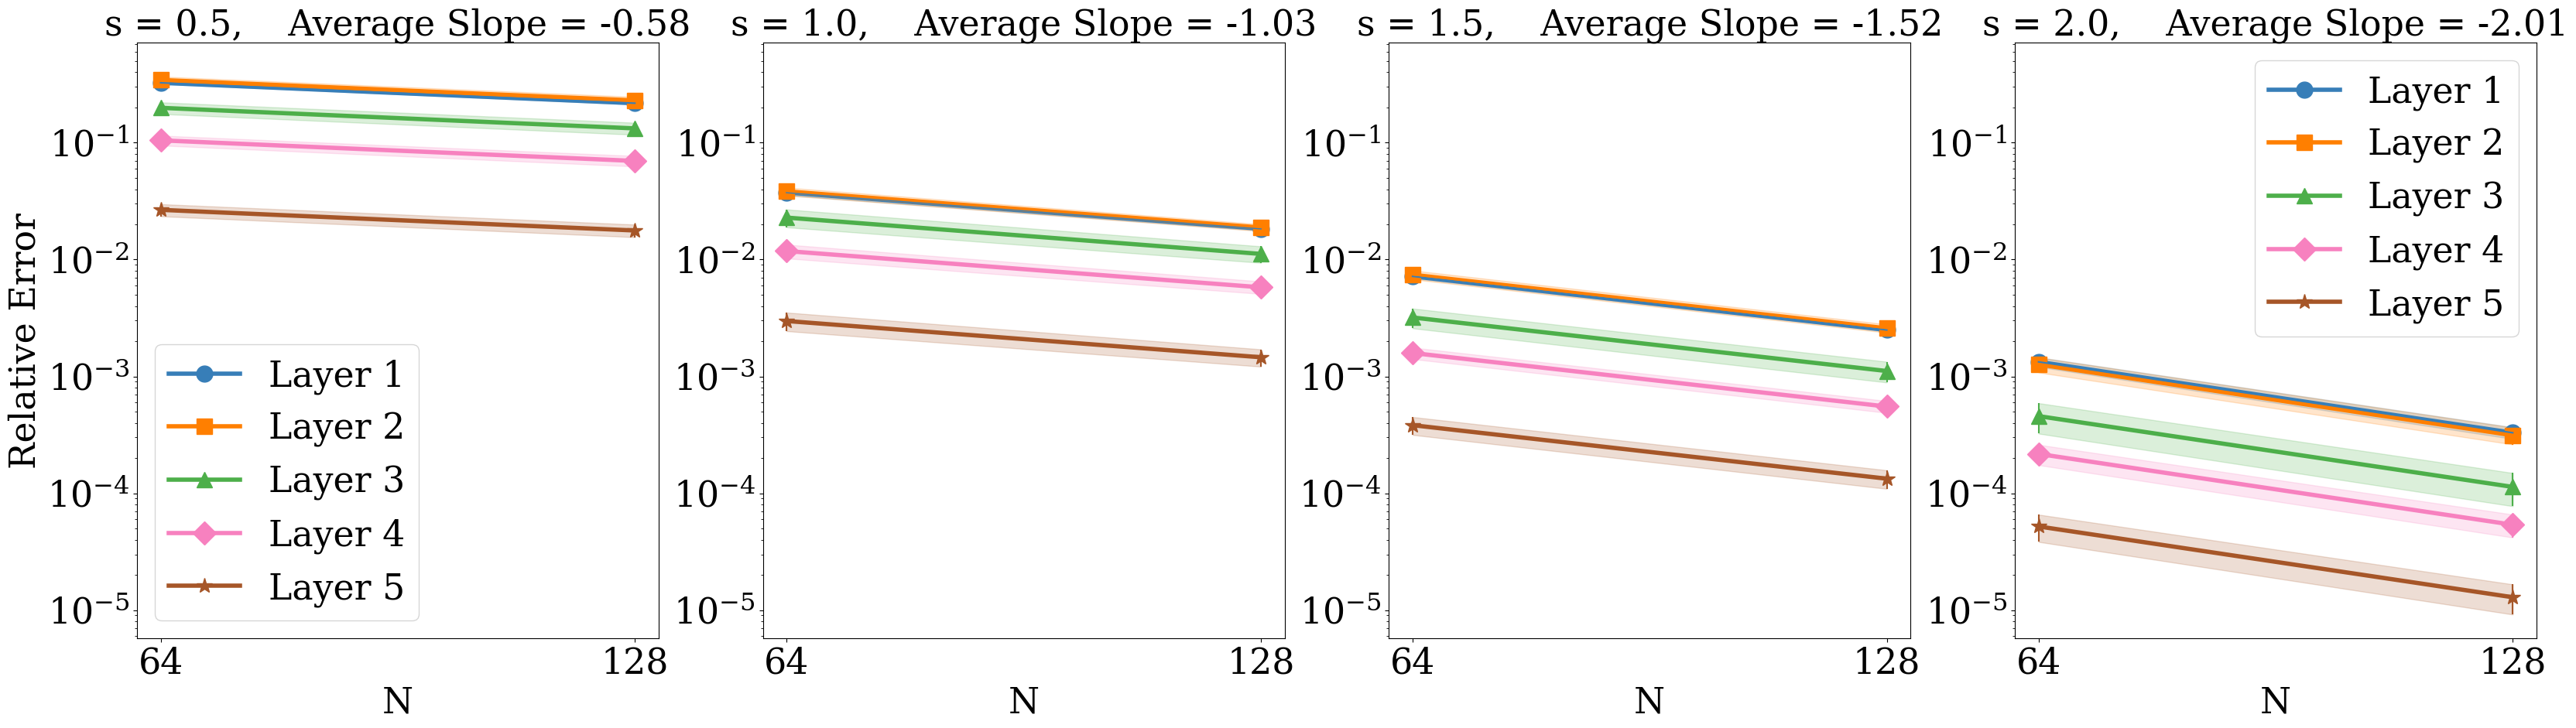

In [35]:
plot_err_vs_N(all_err_s_norm,plot_sizes,'err_vs_N_default')

## Evaluate Default ReLU Model and plot

In [ ]:
model_name = 'default_model_relu'
all_err_s_relu, true_norms_s_relu = evaluate_model(model_name,s_vals, sizes)
all_err_s_norm_relu = normalize_err(all_err_s_relu,true_norms_s_relu)
save_data(all_err_s_relu, true_norms_s_relu, all_err_s_norm_relu, model_name)

In [ ]:
plot_err_vs_N(all_err_s_norm_relu,plot_sizes,'err_vs_N_default_relu')

## Evaluate Default Model with All 10x and plot

In [36]:
model_name = 'default_model_10xall'
all_err_s_10xall, true_norms_s_10xall = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_10xall = normalize_err(all_err_s_10xall,true_norms_s_10xall)

save_data(all_err_s_10xall, true_norms_s_10xall, all_err_s_norm_10xall, model_name)


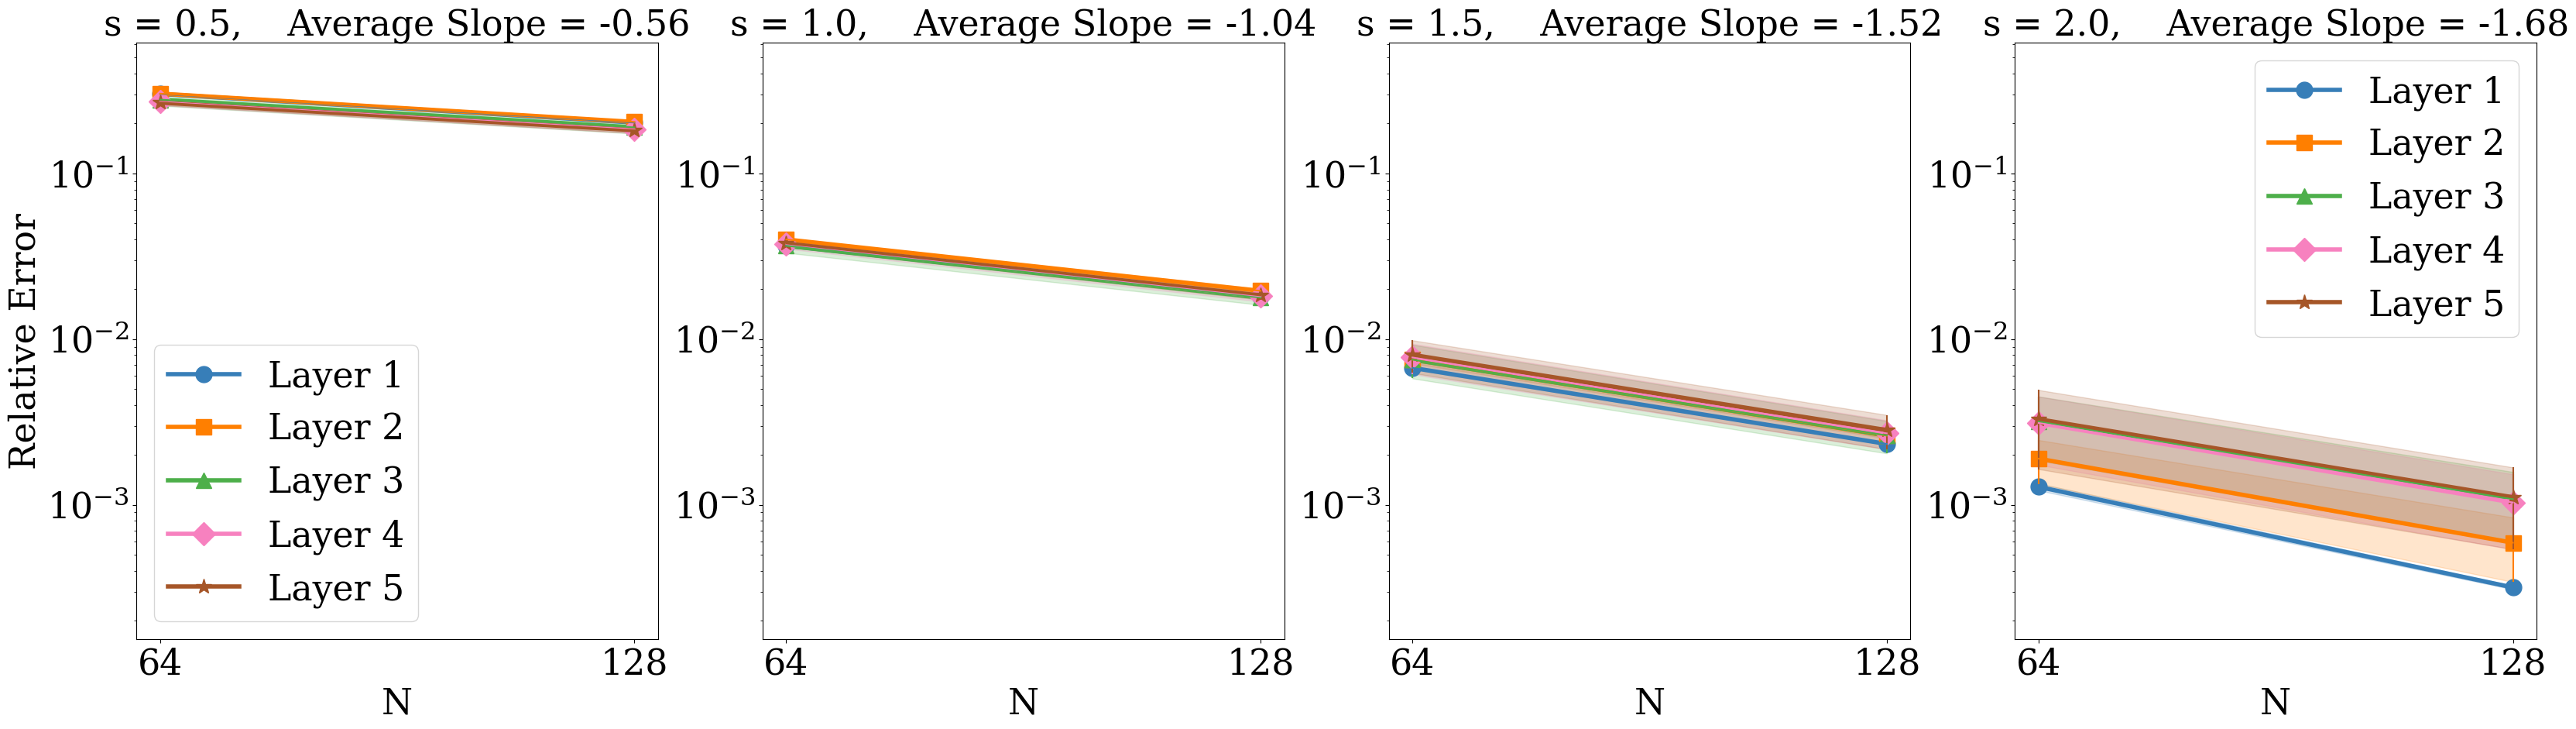

In [37]:
plot_err_vs_N(all_err_s_norm_10xall,plot_sizes,'err_vs_N_default_10xall')

## Evaluate Default Model with 10x Spectral and Plot

In [38]:
model_name = 'default_model_10xspec'
all_err_s_10xspec, true_norms_s_10xspec = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_10xspec = normalize_err(all_err_s_10xspec,true_norms_s_10xspec)
save_data(all_err_s_10xspec, true_norms_s_10xspec, all_err_s_norm_10xspec, model_name)

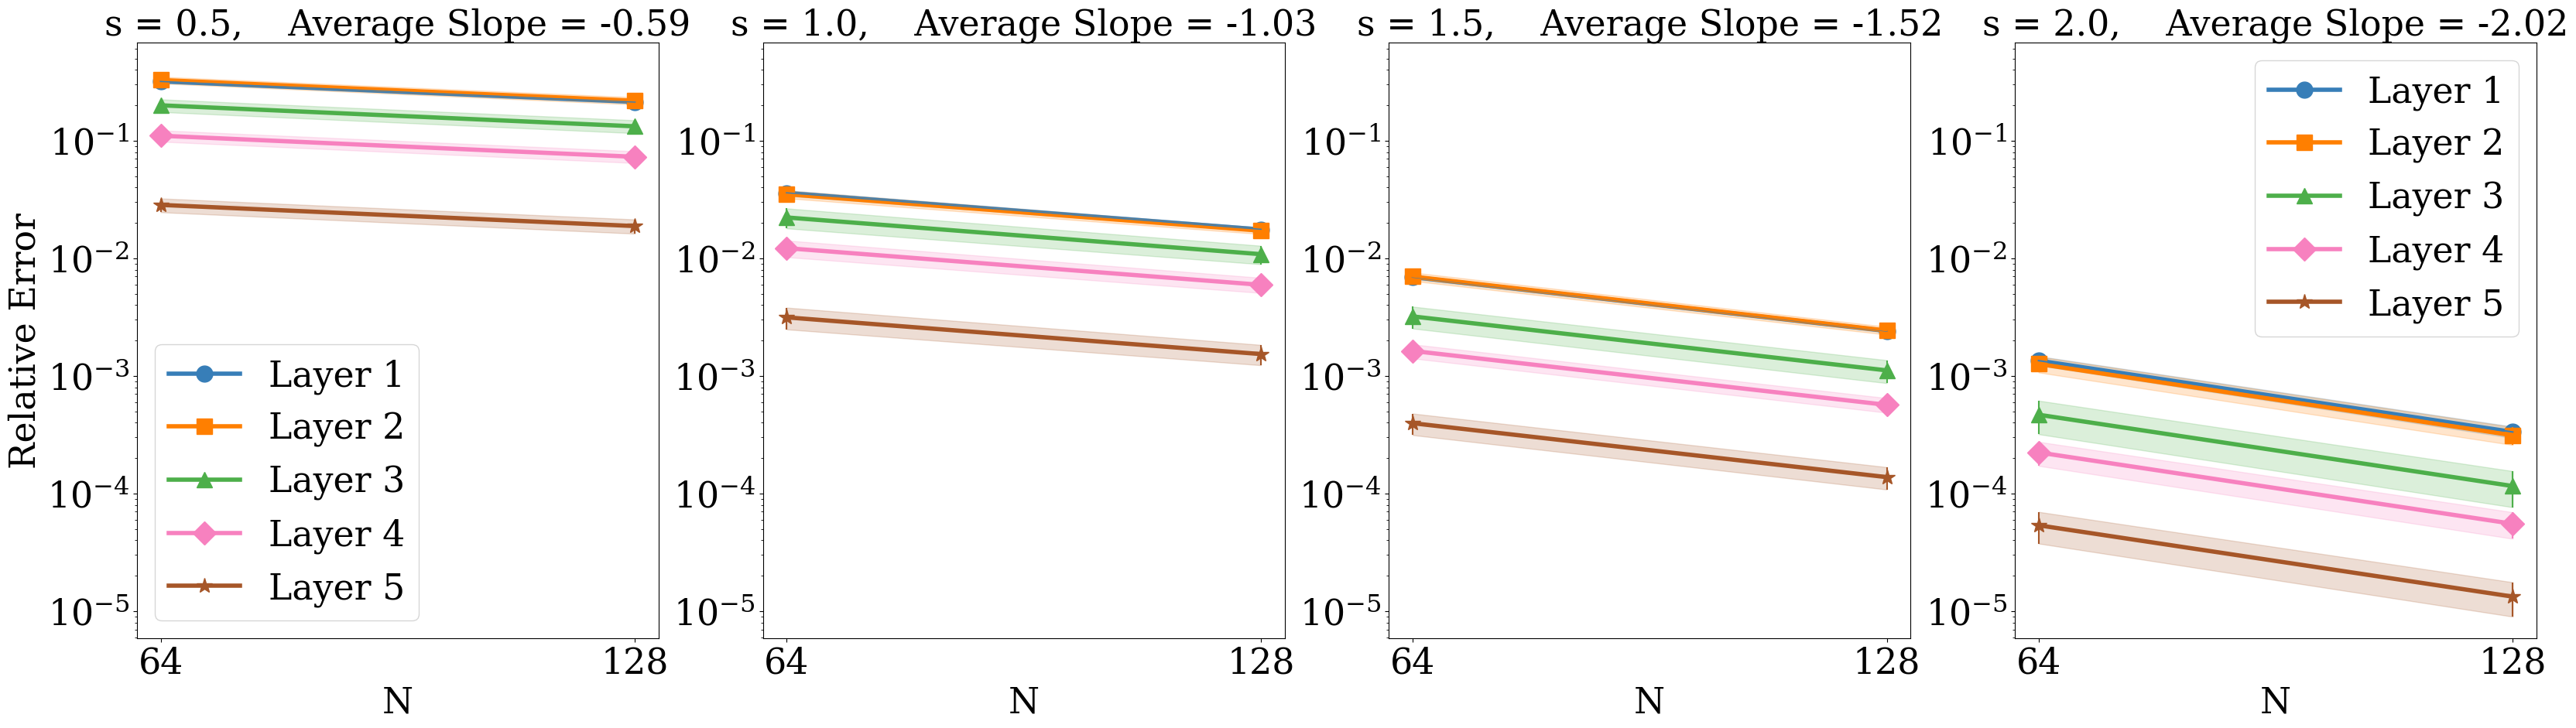

In [39]:
plot_err_vs_N(all_err_s_norm_10xspec,plot_sizes,'err_vs_N_default_10xspec')

## Evaluate Default Model with 100x Spectral and Plot

In [40]:
model_name = 'default_model_100xspec'
all_err_s_100xspec, true_norms_s_100xspec = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_100xspec = normalize_err(all_err_s_100xspec,true_norms_s_100xspec)
save_data(all_err_s_100xspec, true_norms_s_100xspec, all_err_s_norm_100xspec, model_name)

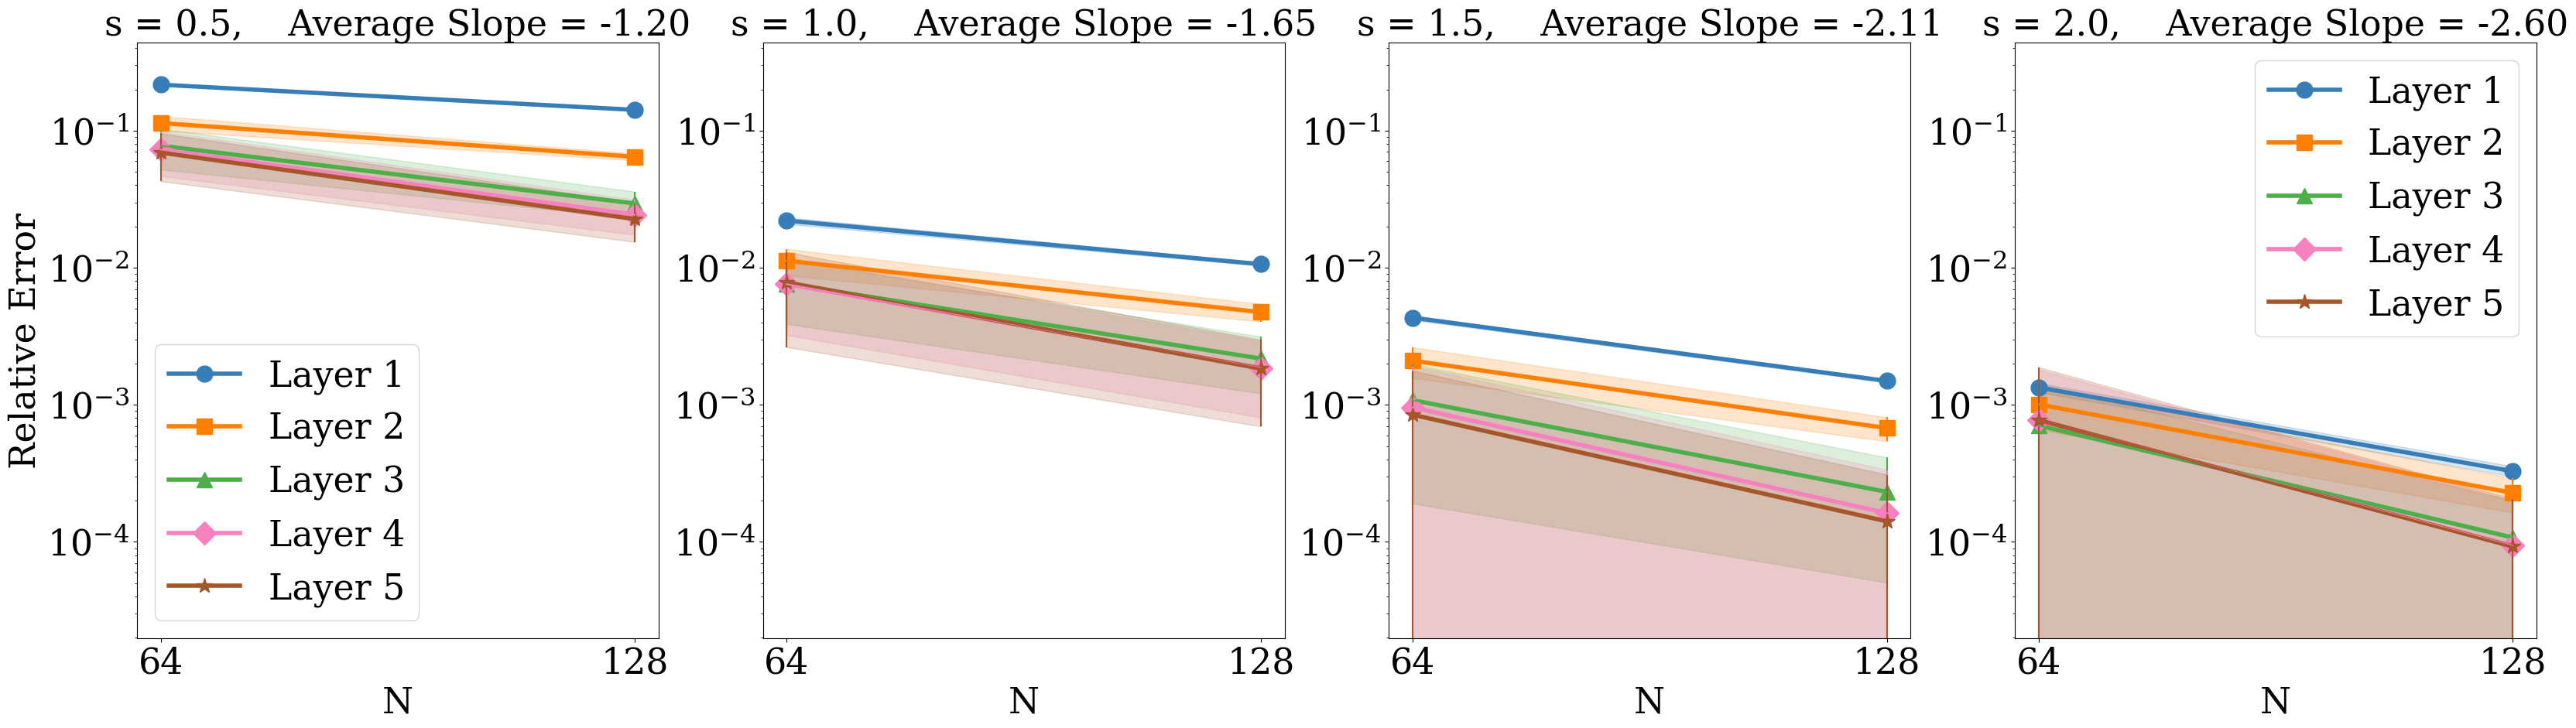

In [41]:
plot_err_vs_N(all_err_s_norm_100xspec,plot_sizes,'err_vs_N_default_100xspec')

## Evaluate U[0,1] Model and plot

In [42]:
model_name = 'uniform01'
all_err_s_unif, true_norms_s_unif = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_unif = normalize_err(all_err_s_unif,true_norms_s_unif)
save_data(all_err_s_unif, true_norms_s_unif, all_err_s_norm_unif, model_name)

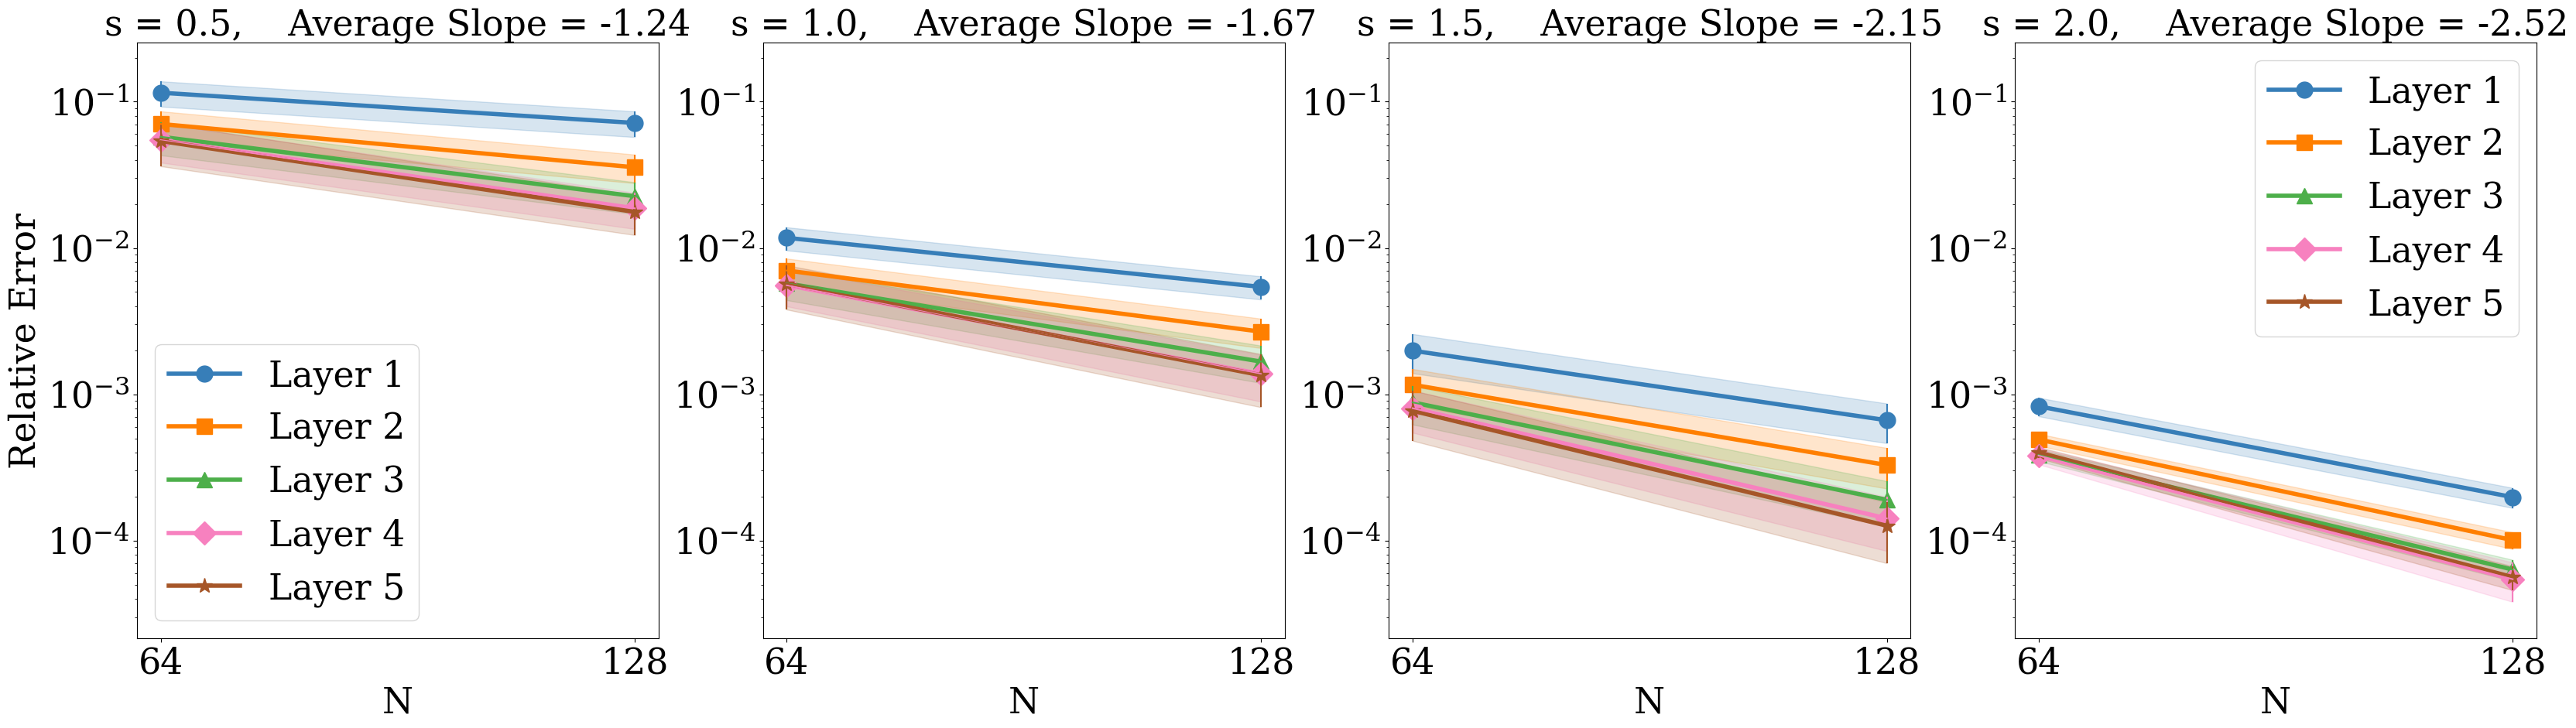

In [43]:
plot_err_vs_N(all_err_s_norm_unif,plot_sizes,'err_vs_N_uniform01')

## Evaluate all 1s model and plot

In [44]:
model_name = 'allones'
all_err_s_allones, true_norms_s_allones = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_allones = normalize_err(all_err_s_allones,true_norms_s_allones)
save_data(all_err_s_allones, true_norms_s_allones, all_err_s_norm_allones, model_name)

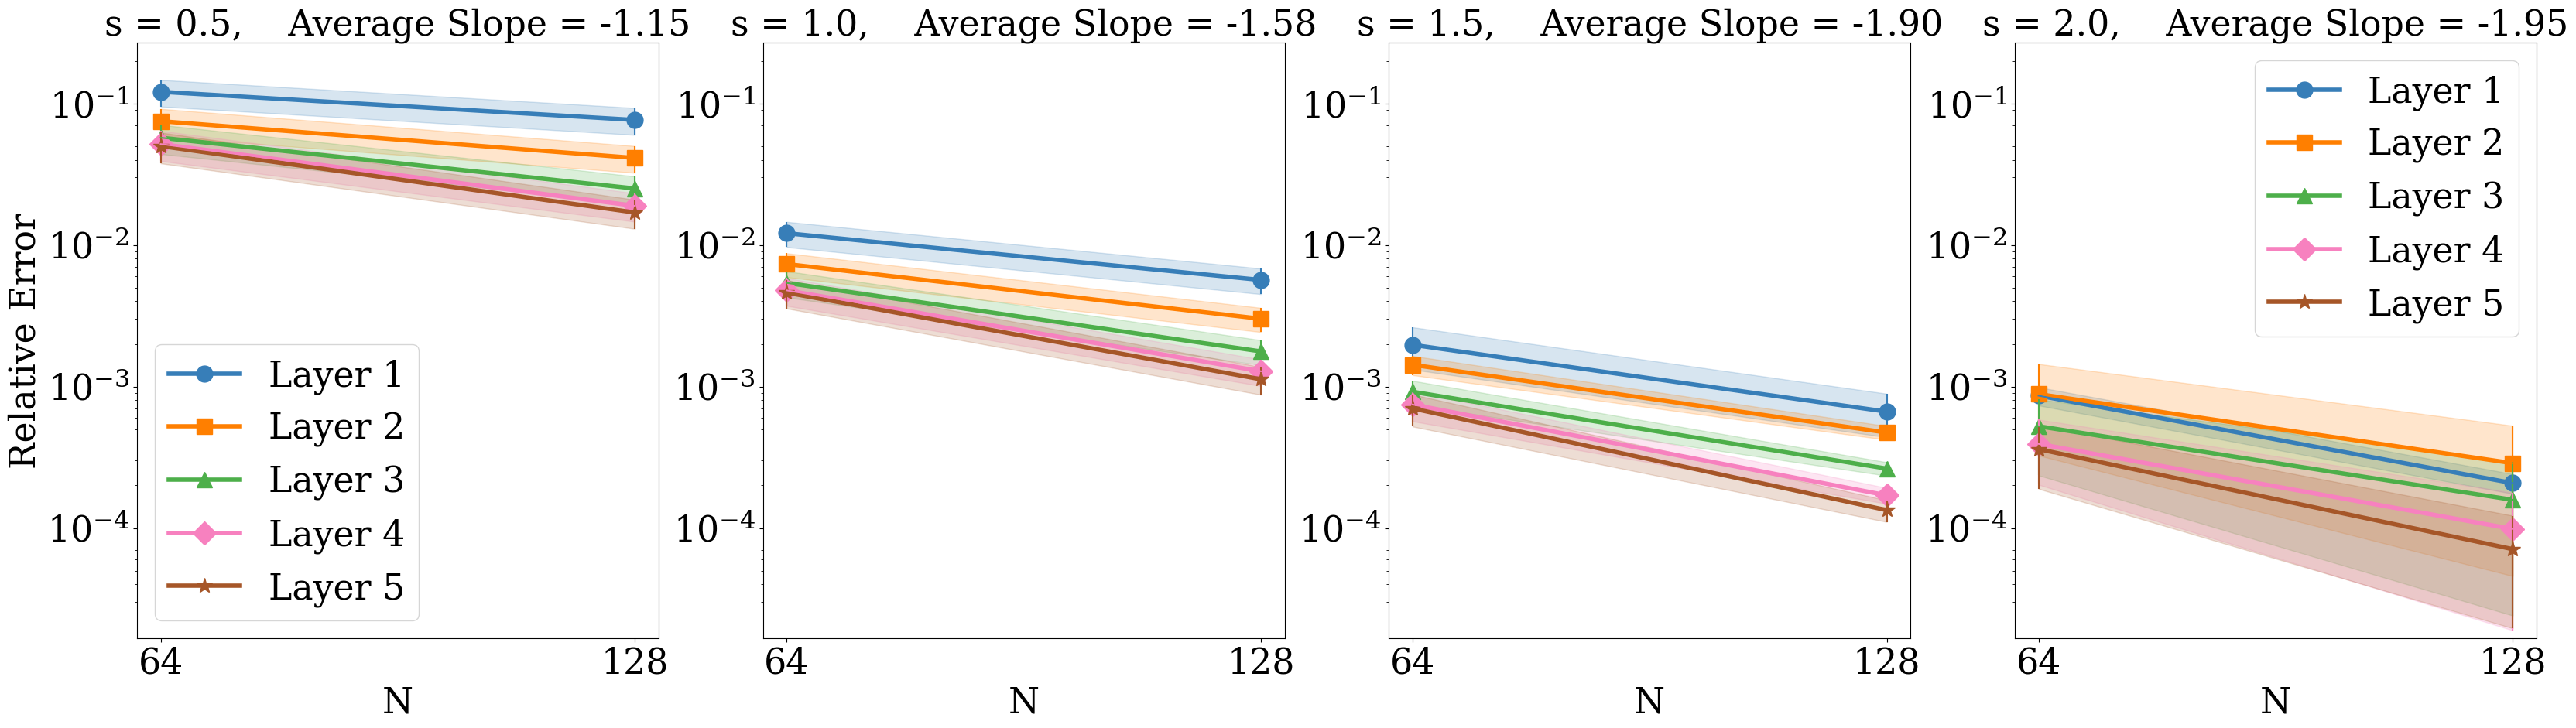

In [45]:
plot_err_vs_N(all_err_s_norm_allones,plot_sizes,'err_vs_N_allones')

## Evaluate periodic grid default model and plot

In [46]:
model_name = 'default_periodic'
all_err_s_periodic, true_norms_s_periodic = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_periodic = normalize_err(all_err_s_periodic,true_norms_s_periodic)
save_data(all_err_s_periodic, true_norms_s_periodic, all_err_s_norm_periodic, model_name)

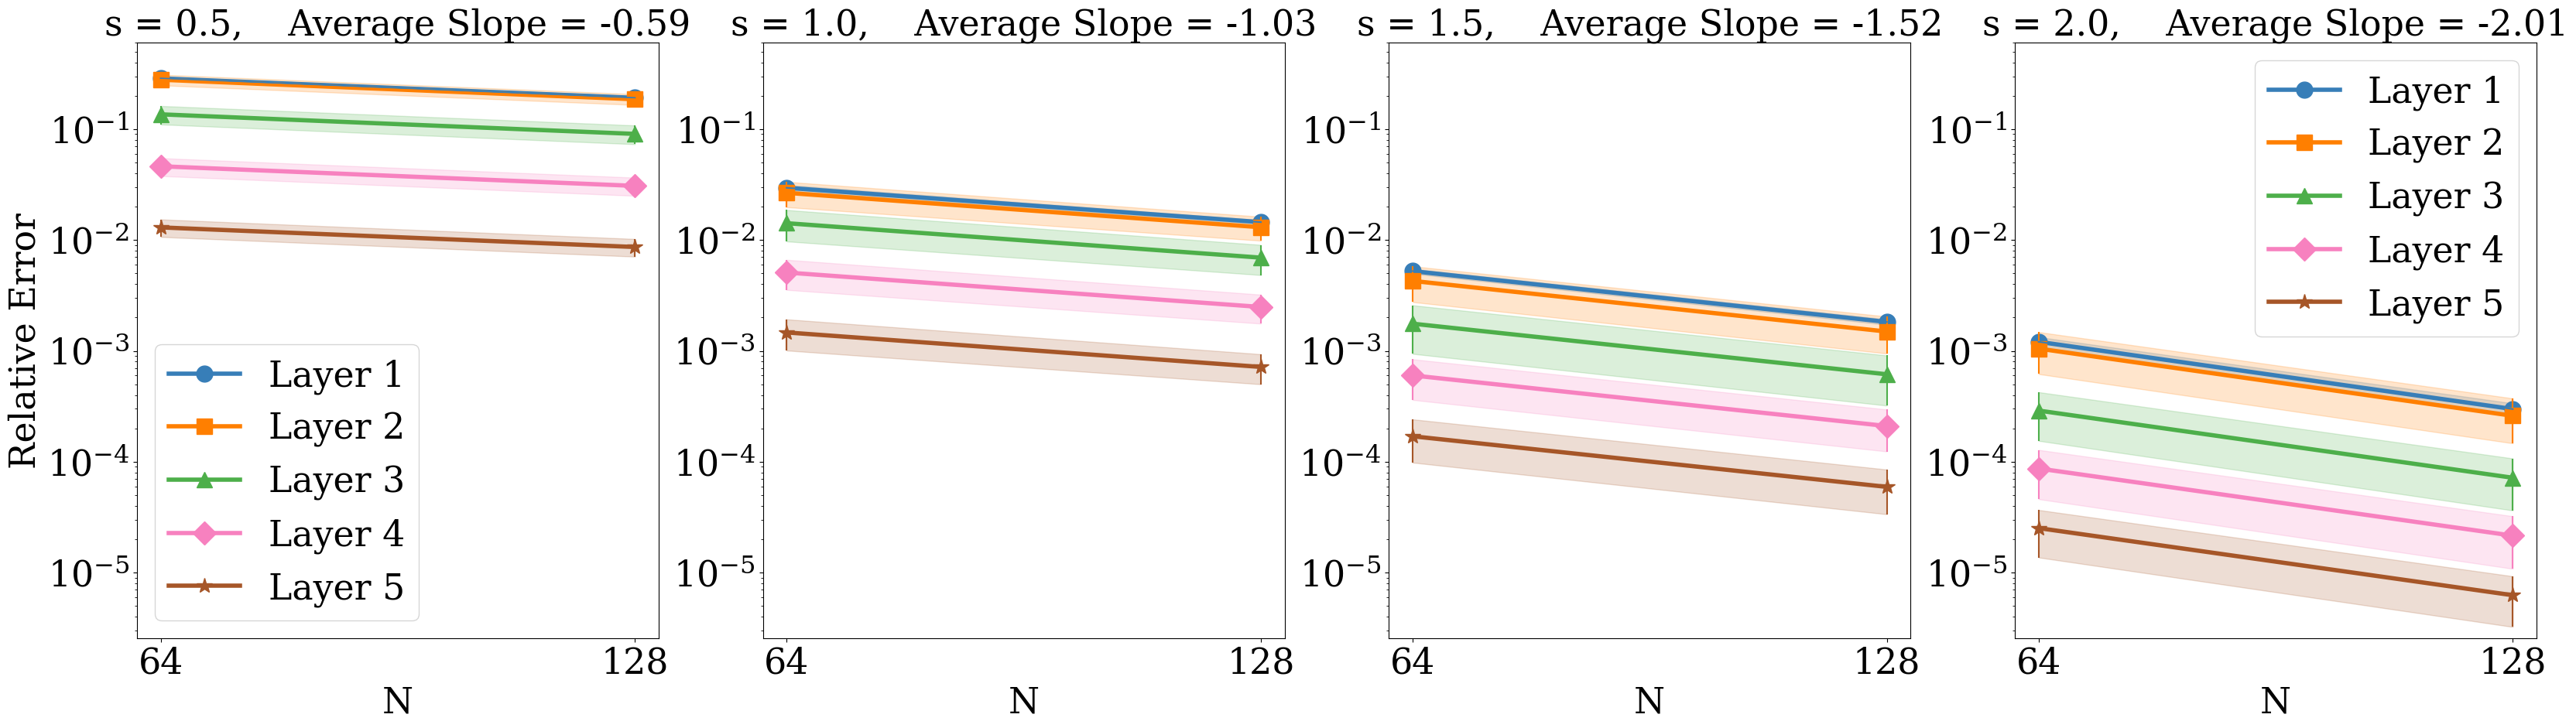

In [47]:
plot_err_vs_N(all_err_s_norm_periodic,plot_sizes,'err_vs_N_default_periodic')

## Evaluate x-y grid default model and plot

In [48]:
model_name = 'default_xy'
all_err_s_xy, true_norms_s_xy = evaluate_model(model_name,s_vals,sizes)
all_err_s_norm_xy = normalize_err(all_err_s_xy,true_norms_s_xy)
save_data(all_err_s_xy, true_norms_s_xy, all_err_s_norm_xy, model_name)

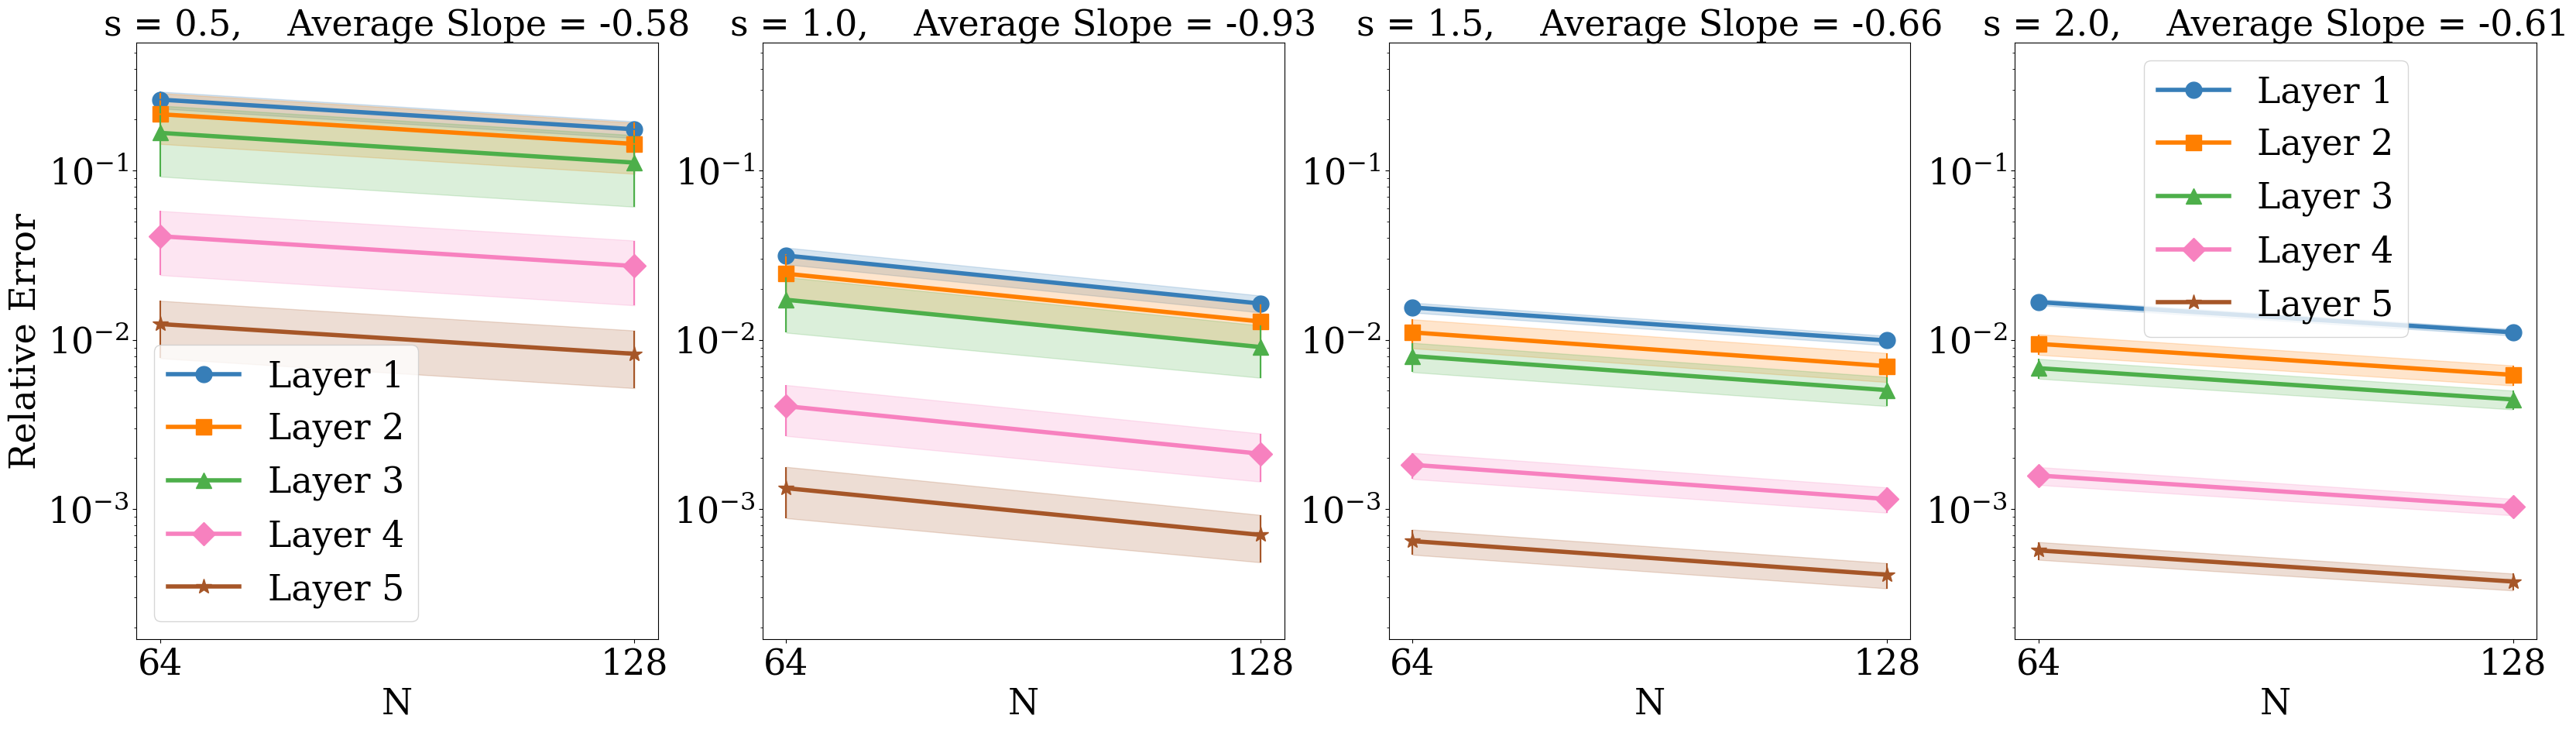

In [49]:
plot_err_vs_N(all_err_s_norm_xy,plot_sizes,'err_vs_N_default_xy')